In [1]:
import pandas as pd
import sys
sys.path.insert(0, "../configs/")
sys.path.insert(0, "../src/")
import test_config as conf
import train_test_split
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM
from keras.layers import Dense
from sklearn import preprocessing


import matplotlib.pyplot as plt
%matplotlib inline


frac = 0.7
Xvar = conf.variables['xvar']
yvar = conf.variables['yvar']


Using TensorFlow backend.
/Users/pluto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pluto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pluto/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pluto/anaconda3/lib/python3.7/site-packages/tenso

In [2]:
df = pd.read_csv("../data_out/Gingin_L4_processed.csv", parse_dates=['DateTime'])

In [3]:
test_df, train_df = train_test_split.layer_train_test_set(df, conf, missing_frac=frac)
# train_df = df[(df["DateTime"]>'2013-01-02') & (df["DateTime"] < '2013-12-02')]
# test_df = df[df["DateTime"]>'2013-12-02']
# test_df['Set_rank'] = 'test'

143:layer_train_test_set:Data used only between dates 2013-03-03 00:00:00 and 2014-03-31 23:30:00 (both inclusive).
164:layer_train_test_set:Test interval start: 2013-03-16 05:00:00 end: 2013-04-15 05:00:00


Number of missing days 30 > 21 = (0.7*30).
Gap condition not satisfied.
Number of missing days 22 > 21 = (0.7*30).
Gap condition not satisfied.


In [4]:
# Combining data frame for scaling
full_df = pd.concat([train_df, test_df])
ymean, ystd = full_df[yvar].mean(), full_df[yvar].std()
yscale = (ymean, ystd)


In [5]:
full_df.shape

(14593, 12)

In [6]:

scaler = preprocessing.StandardScaler()
setrank = full_df['Set_rank'].values
dtime = full_df['DateTime'].values
full_df = scaler.fit_transform(full_df[Xvar+[yvar]])
full_df = pd.DataFrame.from_records(full_df, columns=Xvar + [yvar])
full_df['Set_rank'] = setrank
full_df['DateTime'] = dtime

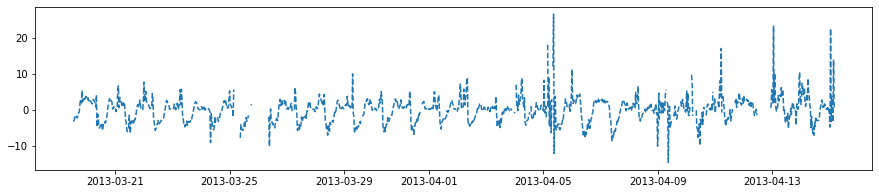

In [7]:
plt.figure(figsize=(15,3))
plt.plot(test_df.DateTime, test_df[yvar], '--')

In [8]:
train_df

,Fc,DateTime,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws,EVI,Set_rank
2927,NaN,2013-03-03 00:00:00,18.459909,1.219846,-36.258529,0.250335,-43.698826,0.011658,24.040018,0.026389,0.205680,layer1_subset4
2928,NaN,2013-03-03 00:30:00,18.176672,0.906406,-34.710579,0.234750,-44.553440,0.011525,23.677082,0.026390,0.205698,layer1_subset4
2929,NaN,2013-03-03 01:00:00,17.893433,0.592966,-33.162628,0.219702,-45.408054,0.011391,23.314144,0.026390,0.205715,layer1_subset5
2930,NaN,2013-03-03 01:30:00,17.618061,0.748956,-33.870252,0.223384,-44.580204,0.011151,22.951208,0.026390,0.205733,layer2
2931,NaN,2013-03-03 02:00:00,17.342691,0.904945,-34.577876,0.227527,-43.752323,0.010911,22.588272,0.026390,0.205750,layer2
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,1.743827,2013-12-31 22:00:00,20.374880,2.601334,-55.324637,0.835112,-85.834908,0.009687,30.876829,0.029335,0.243140,layer1_subset1
17516,0.923067,2013-12-31 22:30:00,20.181881,1.899130,-51.697111,0.794055,-83.052673,0.009765,30.250799,0.029304,0.243165,layer2
17517,0.441727,2013-12-31 23:00:00,19.967979,1.945587,-47.709201,0.736407,-77.023056,0.009932,29.708111,0.029242,0.243190,layer1_subset6
17518,0.477968,2013-12-31 23:30:00,19.565189,1.527907,-53.669059,0.650922,-73.062080,0.010107,29.082529,0.029232,0.243215,layer2


In [9]:
# split a multivariate sequence into samples for LSTM
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
dtime = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), 'DateTime']
Xtrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), Xvar]
ytrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), yvar]

test_filter = (full_df['Set_rank']=='test')
X_test = full_df.loc[test_filter, Xvar]
y_test = full_df.loc[test_filter, yvar]

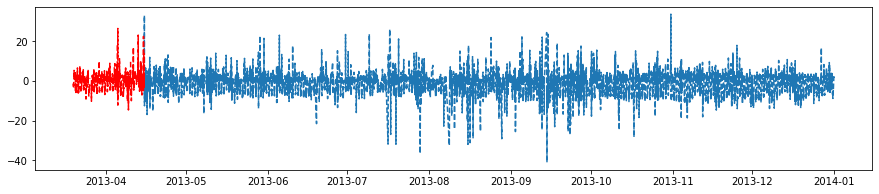

In [11]:
plt.figure(figsize=(15,3))
plt.plot(dtime, ytrain_bothlayers*ystd + ymean,'--')
plt.plot(test_df.DateTime, test_df[yvar], 'r--')

In [28]:
# LSTM -- Single
NSTEPS = 5
NFEATURES = Xtrain_bothlayers.shape[1]

# convert into input/output sequences
dataset_train = np.column_stack((Xtrain_bothlayers, ytrain_bothlayers))
dataset_trainX, dataset_trainy = split_sequences(dataset_train, NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape, Xtrain_bothlayers.shape)

(9892, 5, 9) (9892,) (9896, 9)


In [29]:
# define model
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=(NSTEPS, NFEATURES), activation='relu'))
model_lstm.add(Dense(3, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')


history = model_lstm.fit(dataset_trainX, dataset_trainy,
                            validation_split=0.25, shuffle=False,
                            epochs=20, batch_size=128)

Train on 7419 samples, validate on 2473 samples
Epoch 1/20
7419/7419 [==============================] - 2s 301us/step - loss: 3.4721 - val_loss: 2.0626
Epoch 2/20
7419/7419 [==============================] - 0s 65us/step - loss: 1.4137 - val_loss: 1.4210
Epoch 3/20
7419/7419 [==============================] - 1s 71us/step - loss: 1.0991 - val_loss: 1.1554
Epoch 4/20
7419/7419 [==============================] - 1s 82us/step - loss: 0.9774 - val_loss: 1.0781
Epoch 5/20
7419/7419 [==============================] - 1s 95us/step - loss: 0.9174 - val_loss: 1.0412
Epoch 6/20
7419/7419 [==============================] - 1s 86us/step - loss: 0.8810 - val_loss: 1.0117
Epoch 7/20
7419/7419 [==============================] - 1s 74us/step - loss: 0.8544 - val_loss: 0.9833
Epoch 8/20
7419/7419 [==============================] - 1s 69us/step - loss: 0.8320 - val_loss: 0.9522
Epoch 9/20
7419/7419 [==============================] - 1s 87us/step - loss: 0.8118 - val_loss: 0.9163
Epoch 10/20
7419/7419 [=

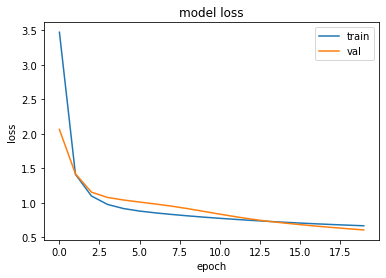

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
dataset_test = np.column_stack((X_test, y_test))
dataset_testX, dataset_testy = split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model_lstm.predict(dataset_testX, verbose=0)

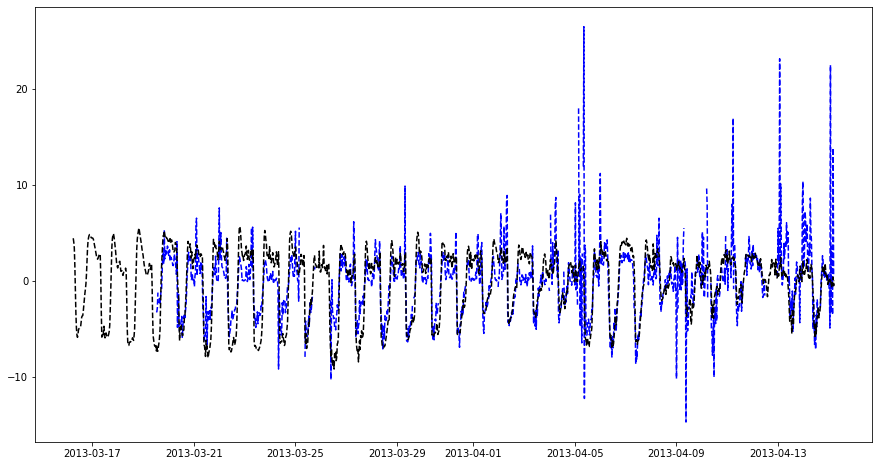

In [27]:
plt.figure(figsize=(15,8))
plt.plot(full_df.loc[test_filter, 'DateTime'], full_df.loc[test_filter, yvar]*ystd + ymean, 'b--')
plt.plot(full_df.loc[test_filter, 'DateTime'][NSTEPS-1:], yhat_test.squeeze()*ystd + ymean, 'k--')